# Final Project: U-Net Segementation of Lung CT for COVID-19



## Load the dataset


In [1]:
from google.colab import files #import the files from colab

To get the kaggle.json, you will need to have an account with Kaggle. Once an account is made you can easily create an API token from the account profile page. By creating a new API token, a kaggle.json file will be downloaded to your computer, which contains your username and API key.

By clicking the "Choose Files" button generated by the following cell you will be able to upload the kaggle.json file.


---


You may need to pip install the Kaggle library:


```
! pip install kaggle
```



In [2]:
files.upload() #upload your kaggle.json file form your computer

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mackenzielooney","key":"7b638866fe85dcaff8f8670154bb87e9"}'}

In [3]:
! mkdir ~/.kaggle #creating folder

In [4]:
! cp kaggle.json ~/.kaggle/ #copying kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json #reading the file with full access

To download the dataset from Kaggle, use the portion of the URL directly following "https://www.kaggle.com/datasets/"

In [6]:
! kaggle datasets download -d andrewmvd/covid19-ct-scans

 98% 1.02G/1.03G [00:07<00:00, 197MB/s]
100% 1.03G/1.03G [00:07<00:00, 150MB/s]


In [7]:
! unzip covid19-ct-scans.zip

Archive:  covid19-ct-scans.zip
  inflating: ct_scans/coronacases_org_001.nii  
  inflating: ct_scans/coronacases_org_002.nii  
  inflating: ct_scans/coronacases_org_003.nii  
  inflating: ct_scans/coronacases_org_004.nii  
  inflating: ct_scans/coronacases_org_005.nii  
  inflating: ct_scans/coronacases_org_006.nii  
  inflating: ct_scans/coronacases_org_007.nii  
  inflating: ct_scans/coronacases_org_008.nii  
  inflating: ct_scans/coronacases_org_009.nii  
  inflating: ct_scans/coronacases_org_010.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm.nii  
  inflating: ct_scans

# Necessary imports

In [8]:
import pandas as pd
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, Dropout, BatchNormalization
import tensorflow as tf
from tqdm import tqdm
import sklearn

# Create a pandas dataframe to keep all of the data
I will only be using the ct_scan and infection_mask portions of the data, but the other frames may be helpful for multiclass segementation.

In [9]:
data = pd.read_csv('metadata.csv')
data['ct_scan'] = data['ct_scan'].str[26:] # .str[26:] gets rid of path info that is not needed by nibabel.load
data['lung_mask'] = data['lung_mask'].str[26:]
data['infection_mask'] = data['infection_mask'].str[26:]
data['lung_and_infection_mask'] = data['lung_and_infection_mask'].str[26:]

In [10]:
def nii_read(file,size):
    '''
    Function to read medical imaging file format and convert to numpy array
    Arguments:
    file - medical imaging file
    size {int} - number of pixels desired
    Return:
    array {np.array} - square numpy array
    '''
    img = nib.load(file) # create nibabel image object
    header = img.header
    array = img.get_fdata() # nibabel.get_fdata() returns array first time called
    array = np.array(array) # starts as numpy.memmap, want as array
    #print(type(array))
    array = np.rot90(array) #otherwise rotated 90 degrees clockwise
    array = cv2.resize(array, dsize = (size, size)).astype('uint8')#,interpolation = cv2.INTER_AREA).astype('uint8') # some have different sizes, will allow it to be consistent regardless
    return(array)

Text(0.5, 1.0, 'Expert Annotation')

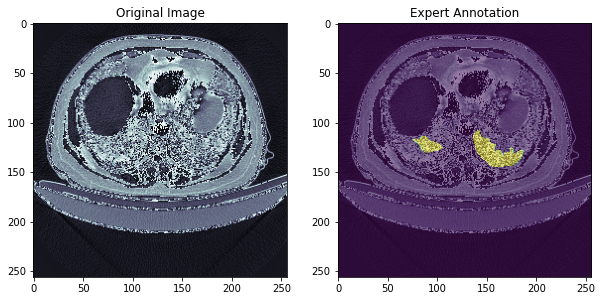

In [11]:
# here to test the nii_read function and see an example of the data
sz = 256
example_ct = nii_read(data['ct_scan'][0],sz)
example_im = nii_read(data['infection_mask'][0],sz)
fig = plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(example_ct[..., 100], cmap = 'bone')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(example_ct[..., 100], cmap = 'bone')
plt.imshow(example_im[..., 100], alpha = 0.5)
plt.title('Expert Annotation')

In [12]:
# runs all of the used data through the nii_read function
ct = []
im = []
for i in range(len(data['ct_scan'])):
  #print(i)
  patient_ct = nii_read(data['ct_scan'][i],sz)
  patient_im = nii_read(data['infection_mask'][i],sz)
  for j in range(patient_ct.shape[-1]):
    ct.append(patient_ct[...,j])
    im.append(patient_im[...,j])

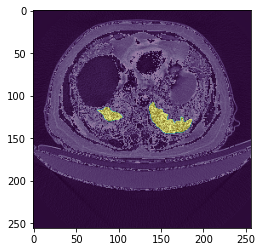

In [13]:
ct = np.array(ct) # after appending all of the data together it needs to be coverted back to an array
im = np.array(im)

In [14]:
ct.shape

(3520, 256, 256)

# Train-Test Split
It would have been better to utilize a function such as KFold, but I did not do this. This uses a "random" generator to split the data into training, testing, and validation.

In [26]:
all_indices = np.arange(0, len(ct))
np.random.shuffle(all_indices)
TEST_FRAC = 0.1
VAL_FRAC = 0.1
test_indices = all_indices[0:int(len(im)*TEST_FRAC)]
val_indices = all_indices[int(len(im)*TEST_FRAC):int(len(im)*TEST_FRAC)+int(len(im)*VAL_FRAC)]
train_indices = all_indices[int(len(ct)*TEST_FRAC)+int(len(im)*VAL_FRAC):]
x_train = ct[train_indices]
y_train = im[train_indices]
x_test = ct[test_indices]
y_test = im[test_indices]
x_val = ct[val_indices]
y_val = im[val_indices]

In [42]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(x_val.shape)

(2816, 256, 256)
(2816, 256, 256)
(352, 256, 256)
(352, 256, 256)


# Defining function to create model
I am primarily working off of the segementation lab, with a few adjustments, like the order of Dropout layers and the activation of the last layer.

In [29]:
def create_unet(input_shape, num_classes):
    input_layer = Input(input_shape)
    x = input_layer
    # down path
    start_filters = 8
    skip_layers = []
    padding = 'valid'
    for i in range(4):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        skip_layers.append(x)
        if i == 3:
            x = Dropout(0.5)(x) # for overfitting
        x = MaxPool2D()(x)
        #x = Dropout(0.5)(x)
    # bottleneck
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    x = Dropout(0.5)(x) # for overfitting
    # up path
    for i in range(4):
        x = UpSampling2D()(x)
        x = tf.concat([skip_layers[-(i+1)], x], axis=-1)
        #x = Dropout(0.5)(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
    #output = Conv2D(num_classes, 1, activation='softmax')(x)
    output = Conv2D(num_classes, 1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

In [30]:
unet_model = create_unet([sz, sz, 1], 1)
unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 8)  80          ['input_3[0][0]']                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 256, 256, 8)  584         ['conv2d_38[0][0]']              
                                                                                                  
 batch_normalization_16 (BatchN  (None, 256, 256, 8)  32         ['conv2d_39[0][0]']        

In [31]:
unet_model.compile(optimizer = "adam", 
                   loss="binary_crossentropy",
                   metrics=["acc"])
history = unet_model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_test, y_test))


Epoch 1/30
44/44 [==============================] - 10s 173ms/step - loss: 0.7000 - acc: 0.6728 - val_loss: 1.2851 - val_acc: 0.2566
Epoch 2/30
44/44 [==============================] - 7s 163ms/step - loss: 0.5998 - acc: 0.9206 - val_loss: 0.6584 - val_acc: 0.6631
Epoch 3/30
44/44 [==============================] - 7s 161ms/step - loss: 0.5338 - acc: 0.9762 - val_loss: 0.4782 - val_acc: 0.9856
Epoch 4/30
44/44 [==============================] - 7s 162ms/step - loss: 0.4630 - acc: 0.9878 - val_loss: 0.3859 - val_acc: 0.9917
Epoch 5/30
44/44 [==============================] - 7s 162ms/step - loss: 0.3908 - acc: 0.9904 - val_loss: 0.3220 - val_acc: 0.9917
Epoch 6/30
44/44 [==============================] - 7s 164ms/step - loss: 0.3249 - acc: 0.9926 - val_loss: 0.2743 - val_acc: 0.9917
Epoch 7/30
44/44 [==============================] - 7s 165ms/step - loss: 0.2697 - acc: 0.9937 - val_loss: 0.2319 - val_acc: 0.9921
Epoch 8/30
44/44 [==============================] - 7s 163ms/step - loss: 0

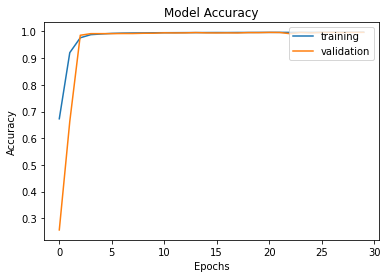

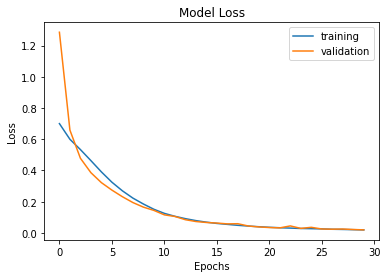

In [32]:
# To ensure an adequate number of epochs, looking for convergence on accuracy and loss.

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training', 'testing'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['training', 'testing'], loc='upper right')
plt.show()

In [33]:
y_predicted = unet_model.predict(x_val, verbose = True)[...,0]

11/11 [==============================] - 1s 18ms/step


Text(0.5, 1.0, 'Predicted Infection')

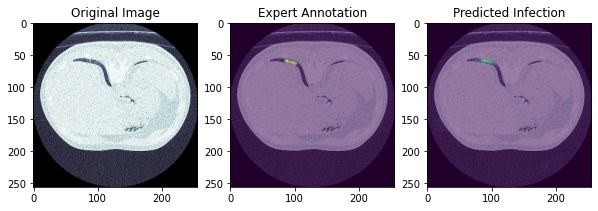

In [36]:
n = 9
fig = plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(x_val[n], cmap = 'bone')
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(x_val[n], cmap = 'bone')
plt.imshow(y_val[n], alpha = 0.5)
plt.title('Expert Annotation')
plt.subplot(1,3,3)
plt.imshow(x_val[n], cmap = 'bone')
plt.imshow(y_predicted[n], alpha = 0.5)
plt.title('Predicted Infection')

In [37]:
def get_metrics(true, pred, threshold):
    '''
    function to get confusion matrix values
    Arguments:
    true {np.array} - the ground truth mask
    pred {np.array} - the predicted mask
    threshold {float} - the cut-off value to determine if a pixel should be considered part of the predicted mask
    Returns:
    tp {int} - number of pixels considered mask in ground truth and predicted
    tn {int} - number of pixels considered not mask in ground truth and predicted
    fp {int} - number of pixels considered not mask in ground truth, mask in predicted
    fn {int} - number of pixels considered mask in ground truth, not mask in predicted
    '''
    image = pred > threshold
    true_list = true.ravel()
    pred_list = image.ravel()

    sum = len(true_list)

    if np.sum(true_list)==sum and np.sum(pred_list)==sum:
        tn, fp, fn, tp = 0, 0, 0, np.float64(len(true_list))

    elif np.sum(true_list)==0 and np.sum(pred_list)==0:
        tn, fp, fn, tp = np.float64(len(true_list)), 0, 0, 0

    else:
      tn, fp, fn, tp = sklearn.metrics.confusion_matrix(true_list, pred_list).ravel().astype(np.float64)

    return tp, tn, fp, fn

def get_all_metrics(true, pred, threshold):
    '''
    function to return total values for full batch of masks, for a given threshold value
    Arguments:
    true {np.array} - ground truth mask
    pred {np.array} - predicted mask
    threshold {float} - the cut-off value to determine if a pixel should be considered part of the predicted mask
    Results:
    the summation of each value (tp,tn,fp,fn) for the full batch at a given threshold
    '''
    results = []

    for i in tqdm(range(len(pred))):
        results.append(get_metrics(true[i], pred[i], threshold))
    
    return np.sum(results, axis=0)

def intersection(tp, tn, fp, fn):
    return tp

def union(tp, tn, fp, fn):
    return tp+fp+fn

def iou(tp, tn, fp, fn):
    return tp / (tp + fp + fn) # https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU

def sensitivity(tp, tn, fp, fn):
    return tp / (tp + fn)

def precision(tp, tn, fp, fn):
    return tp / (tp + fp)

def specificity(tp, tn, fp, fn):
    return 1- (tn / (tn + fp))


def plots(true, pred, thresholds):
    '''
    function tht outputs a series of plots to use as metrics for model performance
    Arguments:
    true {np.array} - ground truth mask
    pred {np.array} - predicted mask
    thresholds {np.array} - the cut-off values to determine if a pixel should be considered part of the predicted mask
    '''
    IoUs = []
    intersections = []
    unions = []
    sensitivities = []
    specificities = []
    precisions = []
    for thresh in thresholds:
        tp, tn, fp, fn = get_all_metrics(true, pred, thresh)
        IoUs.append(iou(tp, tn, fp, fn))
        intersections.append(intersection(tp, tn, fp, fn))
        unions.append(union(tp, tn, fp, fn))
        sensitivities.append(sensitivity(tp, tn, fp, fn))
        specificities.append(specificity(tp, tn, fp, fn))
        precisions.append(precision(tp, tn, fp, fn))
    plt.plot(unions,intersections)
    plt.xlabel("Union")
    plt.ylabel("Intersection")
    plt.title('Intersection Over Union Curve')
    plt.show()
    plt.plot(thresholds,IoUs)
    plt.xlabel("thesholds")
    plt.ylabel("IoU value")
    plt.title('Intersection Over Union vs. Thresholding Value')
    plt.show()
    plt.plot(specificities,sensitivities)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('ROC Curve')
    plt.show()
    plt.plot(sensitivities,precisions)
    plt.xlabel("Sensitivity")
    plt.ylabel("Precision")
    plt.title('Precision-Recall Curve')
    plt.show()

100%|██████████| 352/352 [00:01<00:00, 274.65it/s]


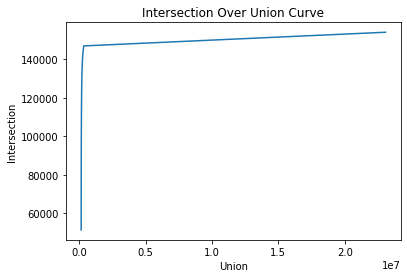

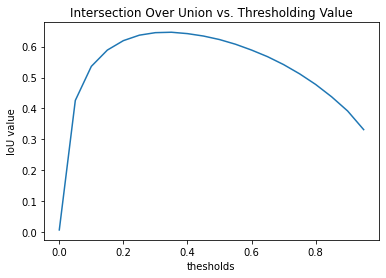

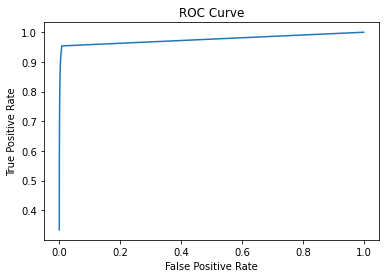

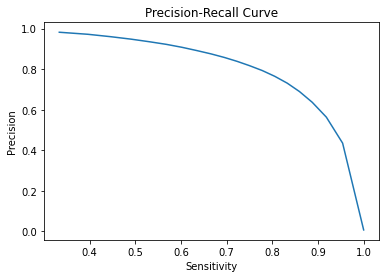

In [38]:
thresholds = np.arange(0,1,0.05)
plots(y_val, y_predicted, thresholds)

In [39]:
import random
def corrupt_block(block, k, s):
    """
    returns a corrupted version of the inputted kxk block
    Arguments:
        block {np.ndarray} -- the kxk sized block to corrupt
        k {int} -- dimension of the block
        s {int} -- the number of sampled pixels 
    Returns:
        block {np.ndarray} -- kxk sized block
    """
    # This commented out method is more precise: it will ensure no pixel is repeated
    # However, it is super super slow (256x256 takes about 5 hours)
    # So for a less robust corruption I used the one below it
    '''
    vector = np.linspace(1,k**2, k**2)
    np.random.shuffle(vector)
    counter = 0
    block = np.asarray(block, dtype = int)
    for i in range(k):
        for j in range(k):
            found = 0
            #print(type(s))
            for l in range(len(vector[0:int(s)])): # only sampling first s places in vector
                if counter == int(vector[l]):
                    found = 1
            if found == 0:
                block[i][j] = -1 # setting the corrupted pixel to bad value
            counter = counter + 1
    '''
    ones = np.ones((k,k))
    for times in range(int(s)): # throw away s samples
      x = random.randint(0,k-1)
      y = random.randint(0,k-1)
      ones[x][y] = 0
    block = np.multiply(block,ones)
    return block

# a function that corruptes the entire image 
def corrupt_image(image, snr,k):
    """
    returns the corrupted image as a dataframe 
    Arguments:
        image {np.ndarray}-- the image you want to corrupt
        k {int} -- length of the block (either 8 or 16)
        s {int} -- the number of sampled pixels 
    Returns:,
        df_corrupted {pd.dataframe} -- the dataframe of the corrupted image
    """
    s = k*k*(1-snr) # throw away this many samples
    rows = image.shape[0]
    cols = image.shape[1]
    assert rows%k == 0 and cols%k == 0
    block = corrupt_block(image, k, s)
    return block

In [40]:
x_test.shape

(352, 256, 256)

In [85]:
def return_illumination_data(sample,snr,sz):
    """
    corrupts sample
    Arguments:
        sample {np.array} -- the image to corrupt
        snr {np.array} -- levels to corrupt
        sz {int} -- size of image
    Returns:
        noise_data {np.ndarray} -- corrupted image
    """
    noise_data = np.zeros((sz, sz, 5))
    channel = 0
    for s in snr:
      noise_data[...,channel] = corrupt_image(sample, s, sz)
      channel += 1
    return noise_data

In [43]:
sub_train = 2816
sub_test = 352
sub_val = 352 #int(0.1*sub_train)
x_train_noise = np.zeros((sub_train,sz,sz,5))
x_test_noise = np.zeros((sub_test,sz,sz,5))
x_val_noise = np.zeros((sub_val,sz,sz,5))

snr = np.array([0.9, 0.7, 0.5, 0.3, 0])
for i in tqdm(range(len(x_train_noise[0:sub_train]))):
      x_train_noise[i] = return_illumination_data(x_train[i],snr,sz)
for i in tqdm(range(len(x_test_noise[0:sub_test]))):
      x_test_noise[i] = return_illumination_data(x_test[i],snr,sz)
for i in tqdm(range(len(x_test_noise[0:sub_test]))):
      x_val_noise[i] = return_illumination_data(x_val[i],snr,sz)

100%|██████████| 352/352 [02:58<00:00,  1.97it/s]


In [44]:
class NonNegative(tf.keras.constraints.Constraint):
    def __call__(self, w):
        return w * tf.cast(tf.math.greater_equal(w, 0.), w.dtype)

class Physical(tf.keras.layers.Layer):
    def __init__(self, is_train=False):
        super(Physical, self).__init__()
        self.is_train = is_train

    def build(self, input_shape):
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05)
        self.pixel_values = tf.keras.layers.Conv2D(filters=1, kernel_size=1,
                                                   strides=1, use_bias=False,
                                                   kernel_initializer=initializer,
                                                   trainable=self.is_train,
                                                   kernel_constraint=NonNegative())
    
    def call(self, inputs):
        return self.pixel_values(inputs)

In [45]:
def create_new_unet(input_shape, num_classes):
    input_layer = Input(input_shape)
    x = input_layer
    x = Physical(is_train = True)(x)
    x = tf.keras.layers.GaussianNoise(0.1)(x)
    # down path
    start_filters = 8
    skip_layers = []
    padding = 'valid'
    for i in range(4):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        skip_layers.append(x)
        if i == 3:
            x = Dropout(0.5)(x) # for overfitting
        x = MaxPool2D()(x)
        #x = Dropout(0.5)(x)
    # bottleneck
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    x = Dropout(0.5)(x) # for overfitting
    # up path
    for i in range(4):
        x = UpSampling2D()(x)
        x = tf.concat([skip_layers[-(i+1)], x], axis=-1)
        #x = Dropout(0.5)(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
    #output = Conv2D(num_classes, 1, activation='softmax')(x)
    output = Conv2D(num_classes, 1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

In [46]:
unet_new_model = create_new_unet([sz, sz, 5], 1)
unet_new_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 physical (Physical)            (None, 256, 256, 1)  5           ['input_4[0][0]']                
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 256, 256, 1)  0          ['physical[0][0]']               
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 8)  80          ['gaussian_noise[0][0]']   

In [47]:
unet_new_model.compile(optimizer = "adam", 
                   loss="binary_crossentropy",#loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=["acc"]) #,tf.keras.metrics.MeanIoU(num_classes=2)])#['accuracy']) #loss=tf.keras.losses.SparseCategoricalCrossentropy()
history = unet_new_model.fit(x_train_noise[0:sub_train], y_train[0:sub_train], epochs=30, batch_size=64, validation_data=(x_test_noise[0:sub_test], y_test[0:sub_test]))

Epoch 1/30
44/44 [==============================] - 11s 203ms/step - loss: 0.7012 - acc: 0.4906 - val_loss: 0.5436 - val_acc: 0.9280
Epoch 2/30
44/44 [==============================] - 8s 185ms/step - loss: 0.6192 - acc: 0.8022 - val_loss: 0.5141 - val_acc: 0.9777
Epoch 3/30
44/44 [==============================] - 8s 183ms/step - loss: 0.5549 - acc: 0.9548 - val_loss: 0.4733 - val_acc: 0.9505
Epoch 4/30
44/44 [==============================] - 8s 184ms/step - loss: 0.4886 - acc: 0.9828 - val_loss: 0.4777 - val_acc: 0.9038
Epoch 5/30
44/44 [==============================] - 8s 185ms/step - loss: 0.4246 - acc: 0.9890 - val_loss: 0.3047 - val_acc: 0.9917
Epoch 6/30
44/44 [==============================] - 8s 185ms/step - loss: 0.3624 - acc: 0.9911 - val_loss: 0.3111 - val_acc: 0.9912
Epoch 7/30
44/44 [==============================] - 8s 186ms/step - loss: 0.3051 - acc: 0.9922 - val_loss: 0.2692 - val_acc: 0.9915
Epoch 8/30
44/44 [==============================] - 8s 185ms/step - loss: 0

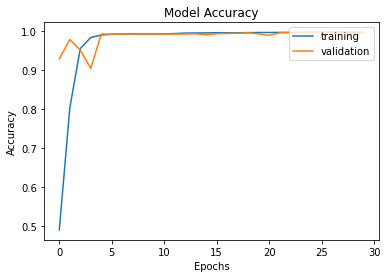

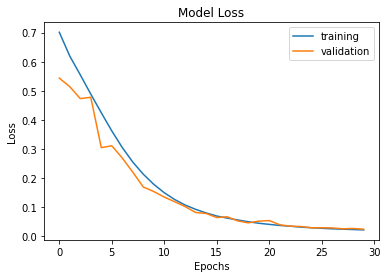

In [48]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training', 'testing'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['training', 'testing'], loc='upper right')
plt.show()

In [49]:
y_predicted_phys = unet_new_model.predict(x_val_noise[0:sub_val], verbose = True)[...,0]

11/11 [==============================] - 1s 27ms/step


# Look at output of just the physical layer

Text(0.5, 1.0, 'After Physical Layer')

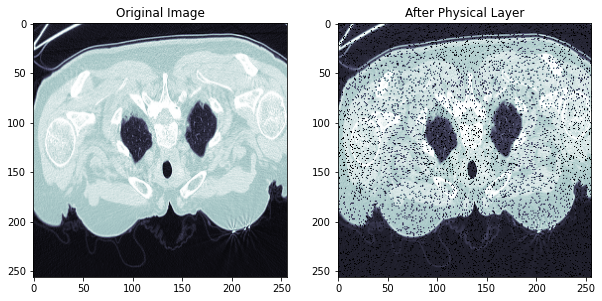

In [50]:
subMod = tf.keras.models.Model(unet_new_model.input, unet_new_model.get_layer(index=0).output)
illum = subMod.predict(x_val_noise[0:sub_val])
fig = plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(x_val[32], cmap='bone')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(illum[32,:,:,0], cmap='bone')
plt.title('After Physical Layer')

# Comparison between predicted and true values

Text(0.5, 1.0, 'Annotated Infection')

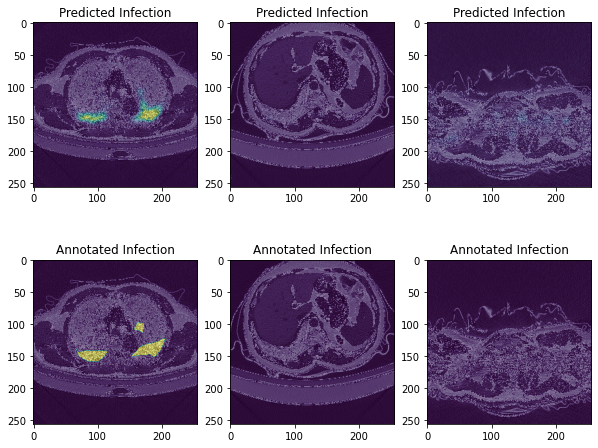

In [51]:
fig = plt.figure(figsize = (10,8))
plt.subplot(2,3,1)
plt.imshow(x_val[1], cmap='bone')
plt.imshow(y_predicted_phys[1], alpha=0.5)
plt.title('Predicted Infection')
plt.subplot(2,3,2)
plt.imshow(x_val[51], cmap='bone')
plt.imshow(y_predicted_phys[51], alpha=0.5)
plt.title('Predicted Infection')
plt.subplot(2,3,3)
plt.imshow(x_val[151], cmap='bone')
plt.imshow(y_predicted_phys[151], alpha=0.5)
plt.title('Predicted Infection')
plt.subplot(2,3,4)
plt.imshow(x_val[1], cmap='bone')
plt.imshow(y_val[1], alpha=0.5)
plt.title('Annotated Infection')
plt.subplot(2,3,5)
plt.imshow(x_val[51], cmap='bone')
plt.imshow(y_val[51], alpha=0.5)
plt.title('Annotated Infection')
plt.subplot(2,3,6)
plt.imshow(x_val[151], cmap='bone')
plt.imshow(y_val[151], alpha=0.5)
plt.title('Annotated Infection')

# Predicted with physical layer

Text(0.5, 1.0, 'Predicted Infection')

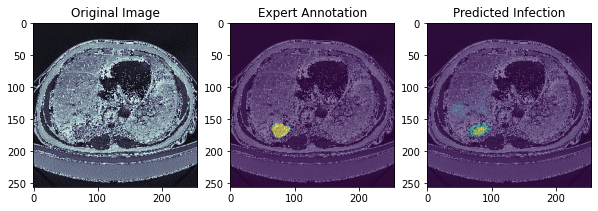

In [68]:
num = 2 #9, 12, 23, 31, 32, 38
fig = plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(x_val[num], cmap = 'bone')
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(x_val[num], cmap = 'bone')
plt.imshow(y_val[num], alpha = 0.5)
plt.title('Expert Annotation')
plt.subplot(1,3,3)
plt.imshow(x_val[num], cmap = 'bone')
plt.imshow(y_predicted_phys[num], alpha = 0.5)
plt.title('Predicted Infection')

# Predicted without physical layer

Text(0.5, 1.0, 'Predicted Infection')

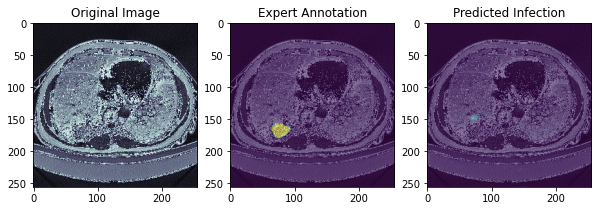

In [69]:
fig = plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(x_val[num], cmap = 'bone')
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(x_val[num], cmap = 'bone')
plt.imshow(y_val[num], alpha = 0.5)
plt.title('Expert Annotation')
plt.subplot(1,3,3)
plt.imshow(x_val[num], cmap = 'bone')
plt.imshow(y_predicted[num], alpha = 0.5)
plt.title('Predicted Infection')

# Better look at the noise used to make the physical layer

Text(0.5, 1.0, 'Physical Layer')

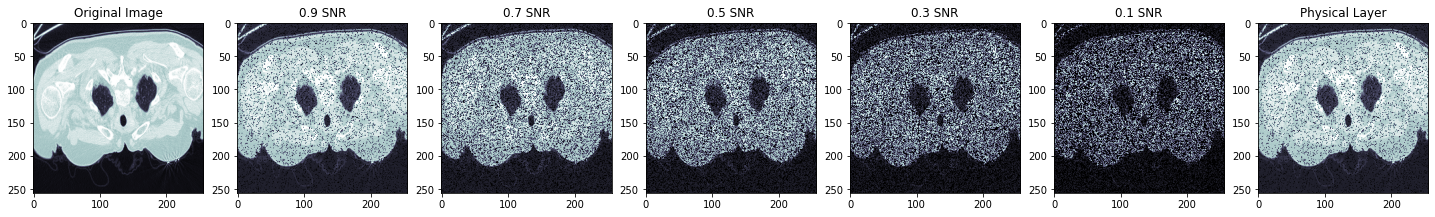

In [54]:
fig = plt.figure(figsize = (25,5))
plt.subplot(1,7,1)
plt.imshow(x_val[32], cmap='bone')
plt.title('Original Image')
plt.subplot(1,7,2)
plt.imshow(x_val_noise[32,:,:,0], cmap='bone')
plt.title('0.9 SNR')
plt.subplot(1,7,3)
plt.imshow(x_val_noise[32,:,:,1], cmap='bone')
plt.title('0.7 SNR')
plt.subplot(1,7,4)
plt.imshow(x_val_noise[32,:,:,2], cmap='bone')
plt.title('0.5 SNR')
plt.subplot(1,7,5)
plt.imshow(x_val_noise[32,:,:,3], cmap='bone')
plt.title('0.3 SNR')
plt.subplot(1,7,6)
plt.imshow(x_val_noise[32,:,:,4], cmap='bone')
plt.title('0.1 SNR')
plt.subplot(1,7,7)
plt.imshow(illum[32,:,:,0], cmap='bone')
plt.title('Physical Layer')

100%|██████████| 352/352 [00:01<00:00, 290.91it/s]


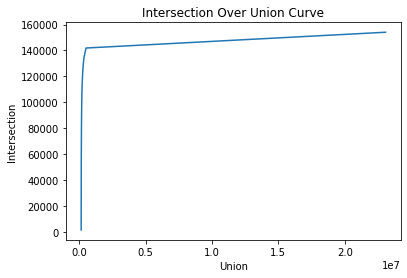

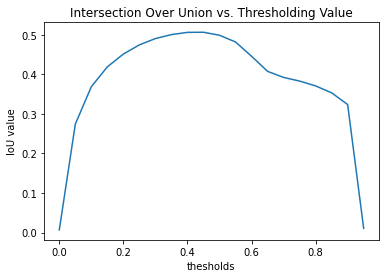

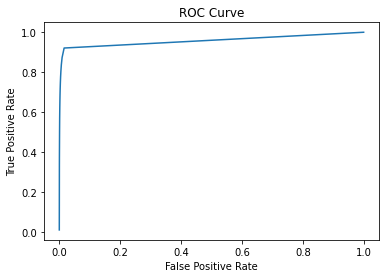

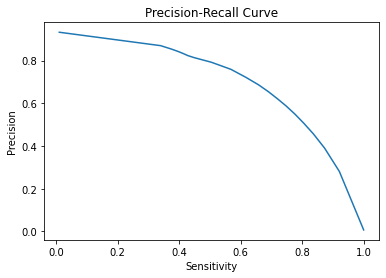

In [55]:
plots(y_val[0:sub_val], y_predicted_phys, thresholds)

# Predicting with noisy image on original (no physical layer) CNN (SNR = 0.9)

In [80]:
y_predicted_hello = unet_model.predict(x_val_noise[...,0], verbose = True)[...,0]

11/11 [==============================] - 0s 20ms/step


Text(0.5, 1.0, 'Predicted Infection')

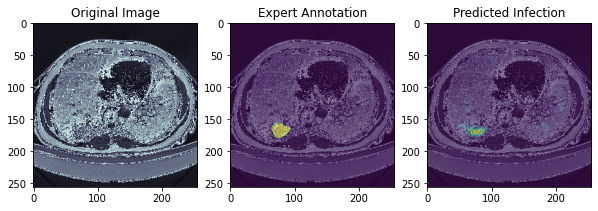

In [81]:
fig = plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(x_val[num], cmap = 'bone')
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(x_val[num], cmap = 'bone')
plt.imshow(y_val[num], alpha = 0.5)
plt.title('Expert Annotation')
plt.subplot(1,3,3)
plt.imshow(x_val[num], cmap = 'bone')
plt.imshow(y_predicted_hello[num], alpha = 0.5)
plt.title('Predicted Infection')

# Predicting with noisy image on CNN with physical layer (SNR is about 0.9)

In [89]:
x_val_noise_new = np.zeros((sub_val,sz,sz,5))
snr = np.array([0.92,0.91,0.9,0.89,0.87])
for i in tqdm(range(len(x_val_noise_new[0:sub_test]))):
      x_val_noise_new[i] = return_illumination_data(x_val[i],snr)
'''
x_val_noise_new[...,0] = x_val_noise[...,0]
x_val_noise_new[...,1] = x_val_noise[...,0]
x_val_noise_new[...,2] = x_val_noise[...,0]
x_val_noise_new[...,3] = x_val_noise[...,0]
x_val_noise_new[...,4] = x_val_noise[...,0]
'''
y_predicted_hellos = unet_new_model.predict(x_val_noise_new, verbose = True)[...,0]

100%|██████████| 352/352 [01:11<00:00,  4.90it/s]


11/11 [==============================] - 0s 27ms/step


Text(0.5, 1.0, 'Predicted Infection')

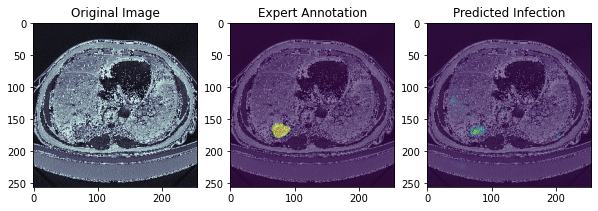

In [90]:
fig = plt.figure(figsize = (10,10))
plt.subplot(1,3,1)
plt.imshow(x_val[num], cmap = 'bone')
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(x_val[num], cmap = 'bone')
plt.imshow(y_val[num], alpha = 0.5)
plt.title('Expert Annotation')
plt.subplot(1,3,3)
plt.imshow(x_val[num], cmap = 'bone')
plt.imshow(y_predicted_hellos[num], alpha = 0.5)
plt.title('Predicted Infection')

# Metrics: predicted with noisy image, CNN no physical layer

100%|██████████| 352/352 [00:01<00:00, 255.96it/s]


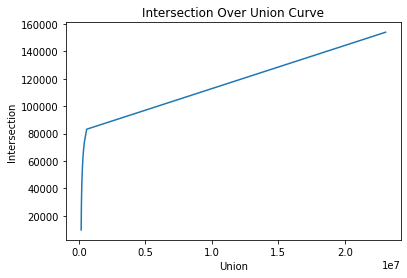

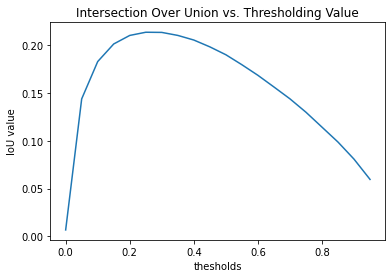

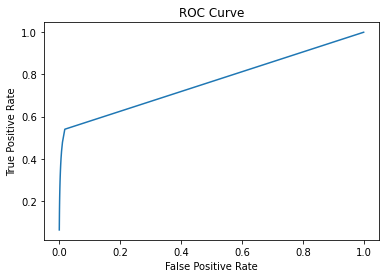

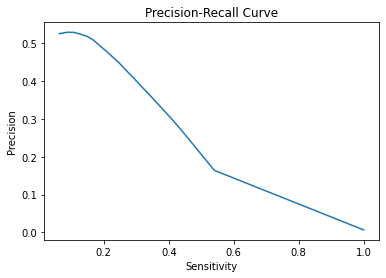

In [84]:
plots(y_val[0:sub_val], y_predicted_hello, thresholds)

# Metrics: predicted with noisy image, CNN with physical layer

100%|██████████| 352/352 [00:01<00:00, 282.72it/s]


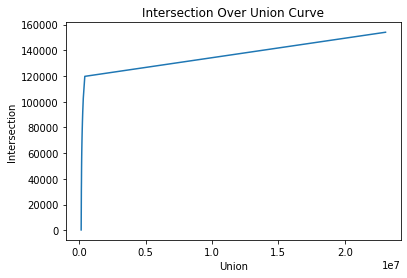

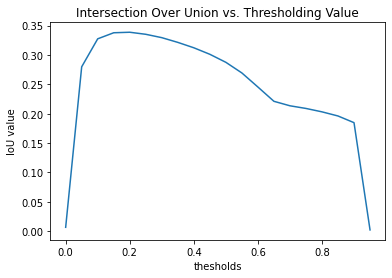

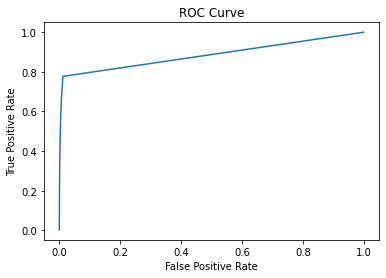

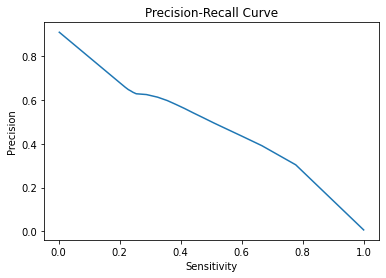

In [91]:
plots(y_val[0:sub_val], y_predicted_hellos, thresholds)